In [102]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [104]:
def make_masks(sess):
    trial_masks = {'left': None, 
                   'right': None, }
        # 'channel_0_left': None,
        #        'channel_0_right': None,
        #        'channel_1_left': None,
        #        'channel_1_right': None}
    left_mask = sess.trial_info['LR']==-1
    trial_masks['left'] = left_mask
    trial_masks['right'] = ~left_mask
    # trial_masks['channel_0_left'] = left_mask
    # trial_masks['channel_0_right'] = ~left_mask
    # trial_masks['channel_1_left'] = left_mask
    # trial_masks['channel_1_right'] = ~left_mask

    return trial_masks

In [105]:
def get_field_info(shuff_thresh, trial_means):
    field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

    for k, thresh in shuff_thresh.items():
        
        sig_bins = trial_means[k]>thresh
    
        # eliminate fields that start at first bin of track or end at last bin of track
        
    
        ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
        
        for _ledge in ledges:
    
            rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
            _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
            # print(_redge.size)
            if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
                field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
    
    
    for k,v in field_info.items():
        field_info[k]=np.array(v)

    return field_info

In [106]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
# sparse_mice[3:4]
sparse_mice[3:]

('SparseKO_06',
 'SparseKO_08',
 'SparseKO_09',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13')

In [130]:
def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = self.timeseries[df_key]

    if 'channel_0' in df_key:
        keep = np.arange(df.shape[1]) % 2 ==0 
    elif 'channel_1' in df_key:
        keep = np.arange(df.shape[1]) % 2 == 1
    else: 
        raise ValueError(f"df_key '{df_key}' must include channel")

    unmux = df[:,keep]
    self.timeseries[df_key] = unmux 


    # also reverse mux for frames and save in seperate structure

    

In [136]:
reverse_mux_alignment(sess, df_key = 'channel_0_spks_speed_filt')

In [135]:
sess.vr_data['t'][chan0_nanmask]

0         0.000000
2         0.000000
4         0.000000
6         0.000000
8         0.000000
           ...    
46422    40.587414
46424    40.892043
46426    41.184669
46428    41.572868
46430    42.003547
Name: t, Length: 23216, dtype: float64

In [148]:
def make_even(inds):
    inds = np.array(inds, dtype=np.int64)
    inds[inds % 2 == 1] += 1
    return inds
def make_odd(inds):
    inds = np.array(inds, dtype=np.int64)
    inds[inds % 2 == 0] += 1
    return inds

In [133]:
chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

In [165]:
F2 = sess.timeseries['channel_0_spks_speed_filt']
starts, stops = make_even(sess.trial_start_inds[trial_masks['right']]), make_even(sess.teleport_inds[trial_masks['right']])
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data['t'][chan0_nanmask], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

0         0.000000
2         0.000000
4         0.000000
6         0.000000
8         0.000000
           ...    
75466    40.826872
75468    41.242897
75470    41.524903
75472    41.934013
75474    42.207468
Name: t, Length: 37738, dtype: float64

In [157]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
shuff_results = {}
trial_means = {}
field_info = {}

for mouse in sparse_mice[3:4]:
    print(mouse)
    shuff_results[mouse] = {}
    trial_means[mouse] = {}
    field_info[mouse] = {}
    if mouse == 'SparseKO_12':
        days = 1
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):

        # set up output dicts
        shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}
        field_info[mouse][day] = {}

        # load sess file
        sess = u.load_single_day(mouse, day)

        # make LR masks
        trial_masks = make_masks(sess)

        # make mux masks 
        chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
        chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F1 = sess.timeseries['channel_0_spks_speed_filt']
        starts, stops = sess.trial_start_inds[trial_masks['left']], sess.teleport_inds[trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data['t'][chan0_nanmask], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F2 = sess.timeseries['channel_0_spks_speed_filt']
        starts, stops = sess.trial_start_inds[trial_masks['right']], sess.teleport_inds[trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data['t'][chan0_nanmask], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F3 = sess.timeseries['channel_1_spks_speed_filt']
        starts, stops = sess.trial_start_inds[trial_masks['left']], sess.teleport_inds[trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data['t'][chan1_nanmask], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F4 = sess.timeseries['channel_1_spks_speed_filt']
        starts, stops = sess.trial_start_inds[trial_masks['right']],sess.teleport_inds[trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data['t'][chan1_nanmask], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # caluculate trial means
        temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks_speed_filt'][trial_masks['left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks_speed_filt'][trial_masks['right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks_speed_filt'][trial_masks['left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks_speed_filt'][trial_masks['right'], : , :],axis=0),
              }
        
        
        # shuff_thresh = shuff_thresh[mouse][day]
        temp_field_info = get_field_info(shuff_thresh, temp_trial_means)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results
        trial_means[mouse][day] = temp_trial_means # save to trial_means
        field_info[mouse][day] = temp_field_info #save to field info
        


SparseKO_06
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


IndexError: boolean index did not match indexed array along dimension 0; dimension is 362 but corresponding boolean dimension is 324

In [119]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results_spks_speed_filt.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [120]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means_spks_speed_filt.pkl','wb') as file:
        pickle.dump(trial_means,file)

In [121]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/field_info_spks_speed_filt.pkl','wb') as file:
        pickle.dump(field_info,file)

In [124]:
import dill
filename = 'C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means_dff.pkl'
with open(filename, 'rb') as file:
    trial_means=dill.load(file)

In [109]:
# change day indexing for mouse 9 
old_dict = field_info['SparseKO_09']
new_dict = {}

for k,v in old_dict.items():
    if k in [2,3,4]:
        new_dict[k+1] = v
    else:
        new_dict[k] = v

field_info['SparseKO_09'] = new_dict

In [83]:
field_info.keys()

dict_keys(['SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

In [125]:
df = {'mouse': [],
      'cond':[],
      'ttype':[],
      'day':[],
      'field_width':[],
      'n_fields':[]}

days = 6

for mouse in sparse_mice[3:]:
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):
        if mouse == 'SparseKO_09' :
            continue
        else:
            
            for key in field_info[mouse][day].keys():
                df['mouse'].append(mouse)
                df['day'].append(day)
    
                if 'channel_0' in key:
                    df['cond'].append('cre') # seperate channel0 from left and right
                elif 'channel_1' in key:
                    df['cond'].append('ctrl')
    
                if mouse == "SparseKO_02" or "SparseKO_05":
                    if 'left' in key:
                        df['ttype'].append('nov')
                    elif 'right' in key:
                        df['ttype'].append('fam')
                elif mouse == "SparseKO_03":
                    if 'left' in key:
                        df['ttype'].append('fam')
                    elif 'right' in key:
                        df['ttype'].append('nov')
    
                f_info = np.array(field_info[mouse][day][key])
    
                if f_info.size > 0:
                    df['field_width'].append(f_info[:,2].mean())
                    cell_list = np.unique(f_info[:,0])
                    df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                else:
                    df['field_width'].append(np.nan)
                    df['n_fields'].append(0)

            
df = pd.DataFrame(df)


In [17]:
np.where(df['mouse']=='SparseKO_09')
# df.iloc[48:64]

(array([], dtype=int64),)

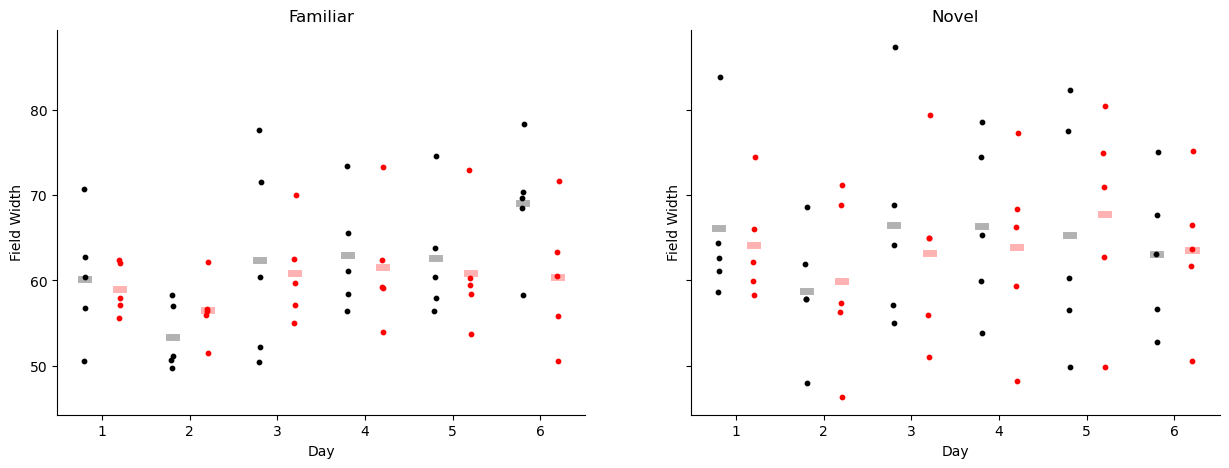

In [126]:
lw = 5
s = 10
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')

# figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))

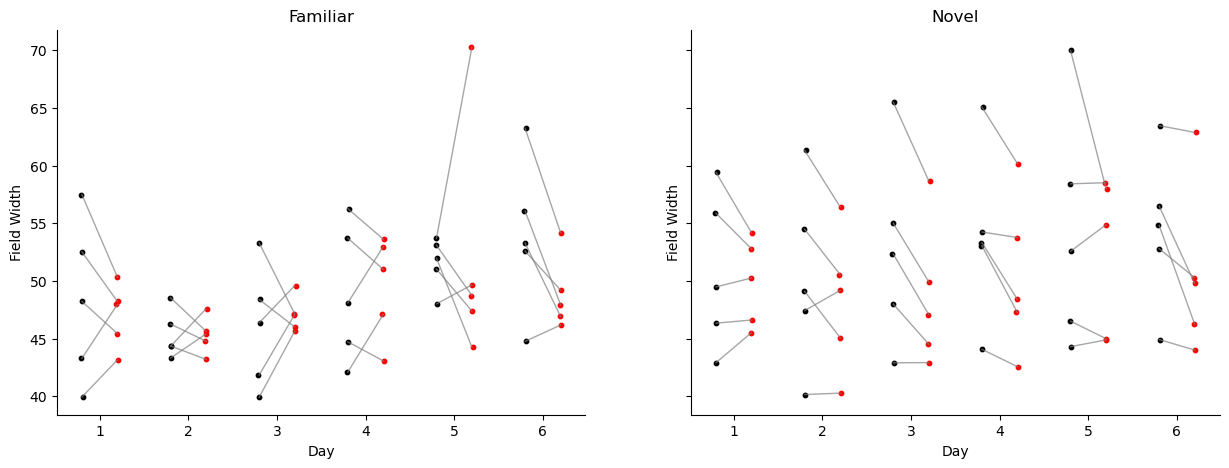

In [112]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
# Iterate through days
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'field_width']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'field_width']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), 10*ctrl_fam['field_width'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), 10*cre_fam['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = 10 * ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_fam.loc[cre_fam['mouse'] == mouse, 'field_width'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'field_width']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'field_width']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), 10*ctrl_nov['field_width'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), 10*cre_nov['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = 10 * ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_nov.loc[cre_nov['mouse'] == mouse, 'field_width'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# Save figure
# figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary_with_lines.pdf"))
# plt.show()

In [98]:
lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
lr

[array([], dtype=float64), array([], dtype=float64)]

0
SparseKO_06
SparseKO_08
SparseKO_09


ValueError: x and y must be the same size

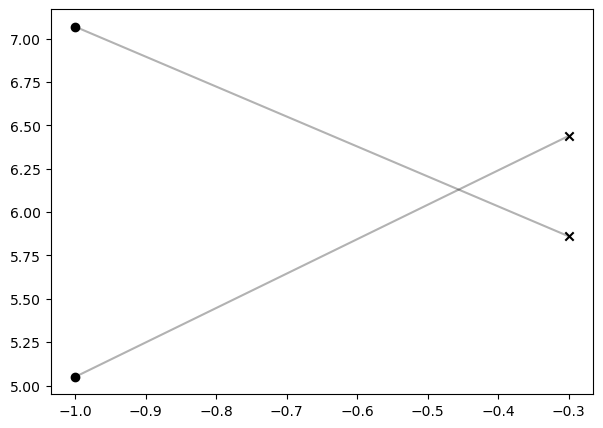

In [127]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    print(day)
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice[3:]:
        print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
        
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice[3:]:
        print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
            
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')
    
# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')

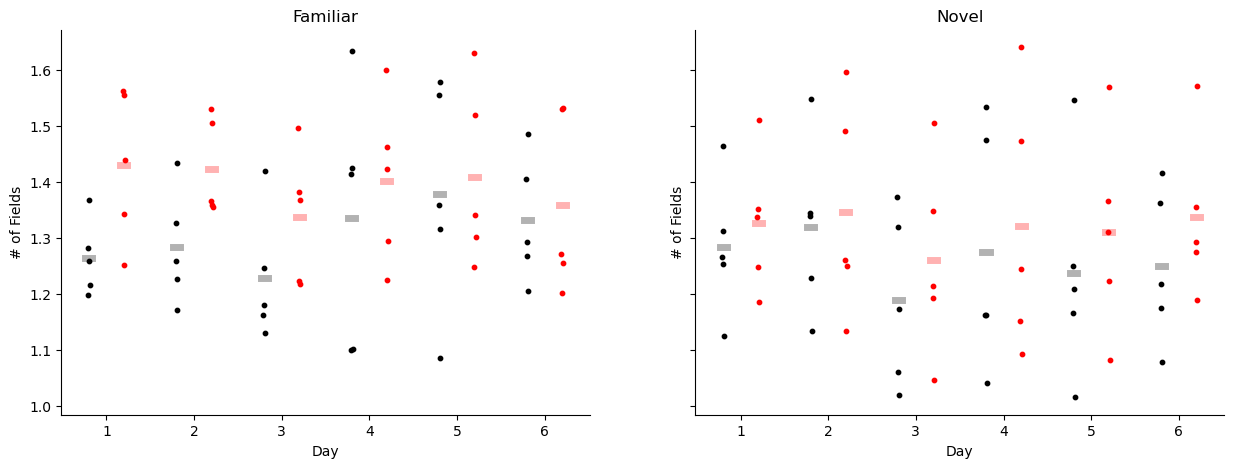

In [128]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))


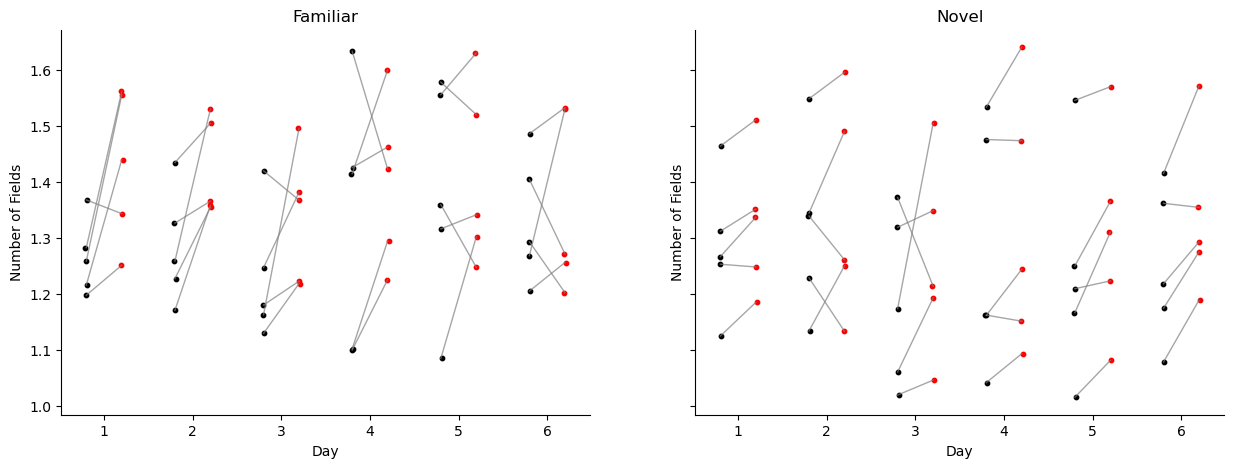

In [129]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), ctrl_fam['n_fields'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), cre_fam['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_fam.loc[cre_fam['mouse'] == mouse, 'n_fields'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), ctrl_nov['n_fields'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), cre_nov['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_nov.loc[cre_nov['mouse'] == mouse, 'n_fields'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Number of Fields')
    ax[a].set_xlabel('Day')

plt.show()

In [98]:
for mouse, days in trial_means.items():
    for day, metrics in days.items():
        for key in list(metrics.keys()):
            if "nov_mean" in key:
                metrics[key.replace("nov_mean","left")] = metrics.pop(key)
            elif "fam_mean" in key:
                metrics[key.replace("fam_mean","right")] = metrics.pop(key)

In [50]:
field_info.keys()

dict_keys(['SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

KeyError: 'channel_0_left'

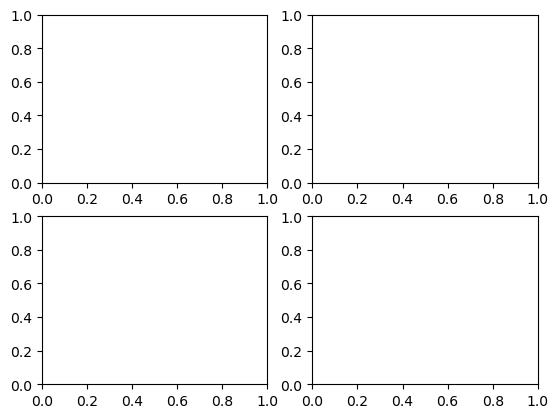

In [49]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    